In [ ]:
!pip install datasets transformers[sentencepiece]

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_dataset(dataset):
    encoded = tokenizer(
        dataset["sentence1"],
        dataset["sentence2"],
        padding=True,
        truncation=True,
        return_tensors='np',
    )
    return encoded.data

tokenized_datasets = {
    split: tokenize_dataset(raw_datasets[split]) for split in raw_datasets.keys()
}

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [4]:
tokenized_datasets['train']

{'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'input_ids': array([[  101,  2572,  3217, ...,     0,     0,     0],
        [  101,  9805,  3540, ...,     0,     0,     0],
        [  101,  2027,  2018, ...,     0,     0,     0],
        ...,
        [  101,  1000,  2057, ...,     0,     0,     0],
        [  101,  1996, 26828, ...,     0,     0,     0],
        [  101,  1996,  2382, ...,     0,     0,     0]]),
 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])}

In [5]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) # No. of labels for out problem is 2

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


"Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference." 

-This dialogue says that BERT wasn't trained for sequence classification(it's just a general purpose language model), and here for our problem we're adding a sequence classification head which need to be trained with our training data

In [9]:
# Case-1 if we try to train the models using all the parameters as string, we won't have much flexibility this way to set the values
# we've to work with the default parameter settings
from tensorflow.keras.losses import SparseCategoricalCrossentropy

num_epochs = 5
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history = model.fit(
    tokenized_datasets['train'],
    np.array(raw_datasets['train']['label']), 
    validation_data=(
        tokenized_datasets['validation'],
        np.array(raw_datasets['validation']['label']),
    ),
    batch_size=8,
    epochs = num_epochs

)

Epoch 1/5
459/459 [==============================] - 204s 406ms/step - loss: 0.6837 - accuracy: 0.6385 - val_loss: 0.6258 - val_accuracy: 0.6838
Epoch 2/5
459/459 [==============================] - 184s 401ms/step - loss: 0.6884 - accuracy: 0.6322 - val_loss: 0.6542 - val_accuracy: 0.6838
Epoch 3/5
459/459 [==============================] - 185s 402ms/step - loss: 0.6695 - accuracy: 0.6445 - val_loss: 0.6246 - val_accuracy: 0.6838
Epoch 4/5
459/459 [==============================] - 184s 401ms/step - loss: 0.6672 - accuracy: 0.6374 - val_loss: 0.7401 - val_accuracy: 0.6838
Epoch 5/5
459/459 [==============================] - 184s 401ms/step - loss: 0.6821 - accuracy: 0.6352 - val_loss: 0.6302 - val_accuracy: 0.6838


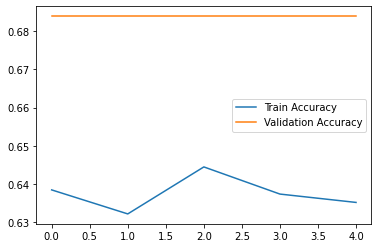

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train Accuracy','Validation Accuracy'])

So, we see from the above plot that though our model isn't overfitting the validation accuracy achieved isn't impressive at all. now instead of repying upon the deafult paramater values we'll use customize the parameters specially the learning rate of Adam optimizer(decaying the lr)

In [11]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
batch_size = 8
num_epochs = 3
#no. of training steps - (toal no. of samples/batch size) * number of epochs
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs
num_train_steps = (len(tokenized_datasets['train']['input_ids']) // batch_size) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.,
    decay_steps=num_train_steps
    )
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=lr_scheduler)

In [28]:
import tensorflow as tf

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) # we reinitialize the model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics = ['accuracy'])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
raw_datasets['train']

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 3668
})

In [29]:
history = model.fit(
    tokenized_datasets['train'],
    np.array(raw_datasets['train']['label']),
    validation_data = (tokenized_datasets['validation'],np.array(raw_datasets['validation']['label'])),
    epochs = num_epochs,
    batch_size = batch_size,
     
)

Epoch 1/3
459/459 [==============================] - 207s 406ms/step - loss: 0.5097 - accuracy: 0.7505 - val_loss: 0.3695 - val_accuracy: 0.8505
Epoch 2/3
459/459 [==============================] - 185s 403ms/step - loss: 0.3653 - accuracy: 0.8561 - val_loss: 0.3695 - val_accuracy: 0.8505
Epoch 3/3
459/459 [==============================] - 185s 403ms/step - loss: 0.3673 - accuracy: 0.8552 - val_loss: 0.3695 - val_accuracy: 0.8505


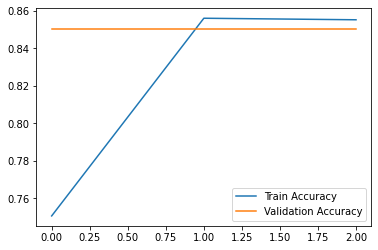

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train Accuracy','Validation Accuracy'])

As we can see the performance of the model on just 3 epochs is better than the previous case(with varying the learning rate). Here one thing to note that the validation accuracy reaches a good accuracy very soons probably because of less samples availables in validation data

In [34]:
preds = model.predict(tokenized_datasets['test'])['logits']
preds[100:110]

array([[-0.00461134, -0.13687246],
       [-0.29815993,  0.10698983],
       [-0.96279913,  1.0946919 ],
       [-1.2156593 ,  1.3064302 ],
       [-1.289045  ,  1.3677822 ],
       [-0.22270663,  0.02672296],
       [ 0.71233535, -0.7942518 ],
       [-1.0720426 ,  1.2210773 ],
       [-1.1694438 ,  1.2811879 ],
       [-0.69289935,  0.6398491 ]], dtype=float32)

In [35]:
class_preds = np.argmax(preds, axis=1)
print(class_preds[100:110])
print(preds.shape, class_preds.shape)

[0 1 1 1 1 1 0 1 1 1]
(1725, 2) (1725,)


In [36]:
# Evaluating model against the mterics of GLUE
from datasets import load_metric

metric = load_metric("glue", "mrpc")
metric.compute(predictions=class_preds, references=raw_datasets['test']['label'])

{'accuracy': 0.8191304347826087, 'f1': 0.8705394190871368}

So we see that on the test dataset the f1 score is quiet good ~ 87%

## How to evaluate f1 for each epoch

In [37]:
class F1_metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        # Initialize our metric by initializing the two metrics it's based on:
        # Precision and Recall
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update our metric by updating the two metrics it's based on
        class_preds = tf.math.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, class_preds, sample_weight)
        self.recall.update_state(y_true, class_preds, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        # To get the F1 result, we compute the harmonic mean of the current
        # precision and recall
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result())) 

In [39]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.,
    decay_steps=num_train_steps
    )
opt = Adam(learning_rate=lr_scheduler)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy', F1_metric()])
history = model.fit(
    tokenized_datasets['train'],
    np.array(raw_datasets['train']['label']),
    validation_data=(tokenized_datasets['validation'], np.array(raw_datasets['validation']['label'])),
    batch_size=8,
    epochs=3
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
459/459 [==============================] - 207s 410ms/step - loss: 0.5219 - accuracy: 0.7385 - f1_score: 0.8185 - val_loss: 0.3661 - val_accuracy: 0.8529 - val_f1_score: 0.8909
Epoch 2/3
459/459 [==============================] - 186s 405ms/step - loss: 0.2393 - accuracy: 0.9070 - f1_score: 0.9309 - val_loss: 0.3795 - val_accuracy: 0.8505 - val_f1_score: 0.8968
Epoch 3/3
459/459 [==============================] - 186s 404ms/step - loss: 0.0501 - accuracy: 0.9847 - f1_score: 0.9887 - val_loss: 0.4408 - val_accuracy: 0.8652 - val_f1_score: 0.9050


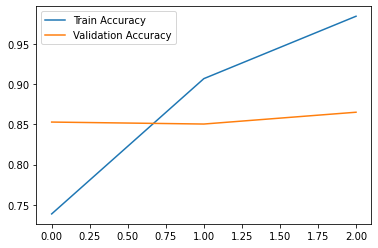

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train Accuracy','Validation Accuracy'])

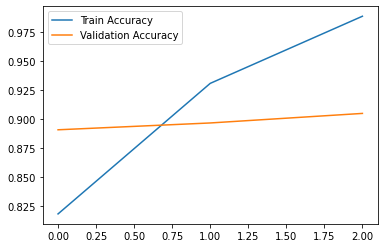

In [42]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.legend(['Train f1-score','Validation f1-score'])